# **Cargue de librerías**

Las siguientes librerías son necesarias para la ejecución correcta del notebook.

* transformers
* huggingface_hub
* datasets
* !pip install accelerate -U

In [11]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_metric, Dataset
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from huggingface_hub import notebook_login
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [12]:
df = pd.read_csv('/content/amazonbaby5000.csv')

In [ ]:
df['rating'].value_counts()

rating
1    3840
0    1160
Name: count, dtype: int64

In [ ]:
df.head()

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


In [ ]:
df.shape

(5000, 2)

In [13]:
def confusion_matrix_graph(y_real, y_pred):
  sns.heatmap(confusion_matrix(y_real, y_pred), annot=True, fmt="d", cmap="Blues")
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Real')
  plt.xticks(rotation=45)
  plt.show()

In [51]:
def confusion_matrix_graph_norm(y_real, y_pred, normalize=True):
  cm = confusion_matrix(y_real, y_pred, normalize='true')
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  sns.heatmap(cm, annot=True, fmt='.2f' if normalize else "d", cmap='Blues',
                xticklabels=[0, 1], yticklabels=[0, 1])
  plt.title('Confusion Matrix Normalized')
  plt.xlabel('Predicted')
  plt.ylabel('Real')
  plt.xticks(rotation=45)
  plt.show()

## **Sentiment analysis**

#### a.) Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de DistilBERT de Huggingface para análisis de sentimiento y lleva a cabo el entrenamiento y evaluación del desempeño con exatitud (accuracy) y matriz de confusión. NOTA: Recuerda obtener el porcentaje de las clases positivas y negativas para tener una idea clara de si el modelo encontrado queda subentrenado.

In [15]:
text = df['review'].values
labels = df['rating'].values

Se realiza la separación del conjunto de datos

In [16]:
train_text, test_text, train_labels, test_labels = train_test_split(text, labels, test_size=0.3, random_state=42)

Es creada una función llamada *create_dataset* que permite tener conjuntos de datos en el formato recibido por el modelo.

In [17]:
def create_dataset(text, labels):
    return Dataset.from_dict({'text': text, 'labels': labels})

In [18]:
train_dataset = create_dataset(train_text, train_labels)
test_dataset = create_dataset(test_text, test_labels)

El modelo es instanciado con los paquetes *AutoTokenizer* y *AutoModelForSequenceClassification* de **transformers** para llamar tanto el tokenizador como el modelo

In [19]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Es usada la misma función para encontrar el accuracy durante la etapa de entrenamiento

In [20]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

Se tokeniza el texto de cada conjunto de datos

In [21]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

In [22]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Es importante tener un token de HF para hacer *login* y poder hacer el push hacía cada repositorio (No es mandatorio, así que se puede omitir en el caso de no subir el modelo). Necesario para la ejecución del entrenamiento.

In [25]:
notebook_login()

Se instancia el *trainer* y se comienza el entrenamiento

In [26]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

repo_name = "finetuning-sentiment-model-5000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [27]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=438, training_loss=0.23592658892069776, metrics={'train_runtime': 240.8268, 'train_samples_per_second': 29.067, 'train_steps_per_second': 1.819, 'total_flos': 619012909608624.0, 'train_loss': 0.23592658892069776, 'epoch': 2.0})

### Accuracy y matriz de confusión

Se prueba el modelo para el conjunto de datos y se obtiene la matriz de confusión

In [28]:
predictions = trainer.predict(tokenized_test)

<ipython-input-20-5688a2e0cb6c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [29]:
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

In [30]:
load_accuracy = load_metric("accuracy")
load_f1 = load_metric("f1")
accuracy = load_accuracy.compute(predictions=preds, references=labels)["accuracy"]
f1 = load_f1.compute(predictions=preds, references=labels)["f1"]

The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [31]:
print(f"El accuracy para el conjunto de prueba es: {round(accuracy,3)}")

El accuracy para el conjunto de prueba es: 0.905


In [32]:
print(f"El f1-score para el conjunto de prueba es: {round(f1,3)}")

El f1-score para el conjunto de prueba es: 0.938


Son ilustradas las matrices de confusión con los valores totales y normalizados (para conocer los porcentajes)



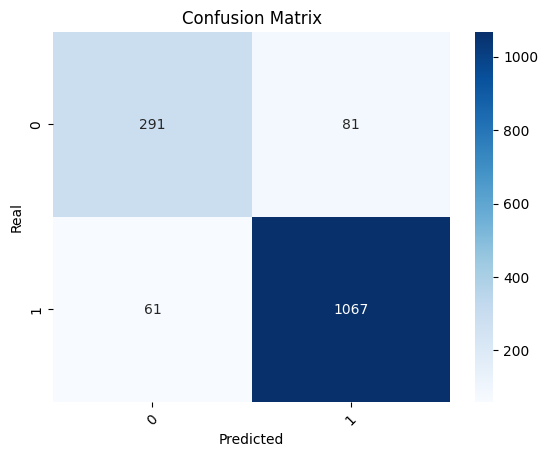

In [43]:
confusion_matrix_graph(preds, labels)

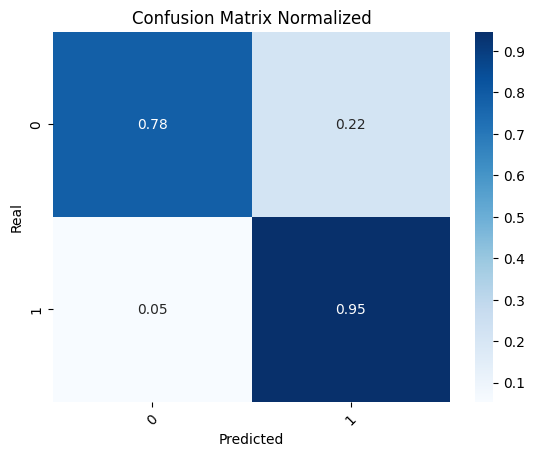

In [52]:
confusion_matrix_graph_norm(preds, labels, normalize=True)

---

#### b.) Realiza una partición del conjunto de entrenamiento en uno nuevo de entrenamiento y validación, con los porcentajes que consideres adecuados y utilizando el mismo modelo DistilBERT del inciso anterior, ajusta sus hiperparámetros (fine-tuning) para entrenar y evaluar el desempeño de este nuevo modelo.

Se hace la partición del conjunto de entrenamiento

In [35]:
train_text_b, test_text_b, train_labels_b, test_label_b = train_test_split(train_text, train_labels, test_size=0.3)

Se crea el format *Dataset* necesario para el entrenamiento

In [36]:
train_dataset_b = create_dataset(train_text_b, train_labels_b)
test_dataset_b = create_dataset(test_text_b, test_text_b)

Son tokenizados los conjuntos de datos

In [37]:
tokenized_train_b = train_dataset_b.map(preprocess_function, batched=True)
tokenized_test_b = test_dataset_b.map(preprocess_function, batched=True)

Map:   0%|          | 0/2450 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Se realiza el entrenamiento

In [38]:
repo_name_b = "finetuning-sentiment-model-3500-samples-train"

training_args_b = TrainingArguments(
   output_dir=repo_name_b,
   learning_rate=3e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer_b = Trainer(
   model=model,
   args=training_args_b,
   train_dataset=tokenized_train_b,
   eval_dataset=tokenized_test_b,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [39]:
trainer_b.train()

Step,Training Loss


TrainOutput(global_step=231, training_loss=0.09817891306691355, metrics={'train_runtime': 306.2241, 'train_samples_per_second': 24.002, 'train_steps_per_second': 0.754, 'total_flos': 783865482531360.0, 'train_loss': 0.09817891306691355, 'epoch': 3.0})

In [44]:
predictions_b = trainer_b.predict(tokenized_test)

Se calculan las métricas para el nuevo entrenamiento

In [45]:
preds_b = predictions_b.predictions.argmax(-1)
labels_b = predictions_b.label_ids

In [46]:
accuracy = load_accuracy.compute(predictions=preds_b, references=labels_b)["accuracy"]
f1 = load_f1.compute(predictions=preds_b, references=labels_b)["f1"]

In [47]:
print(f"El accuracy para el conjunto de prueba es: {round(accuracy,3)}")

El accuracy para el conjunto de prueba es: 0.907


In [48]:
print(f"El f1-score para el conjunto de prueba es: {round(f1,3)}")

El f1-score para el conjunto de prueba es: 0.939


Son ilustradas las matrices de confusión con los valores totales y normalizados (para conocer los porcentajes)


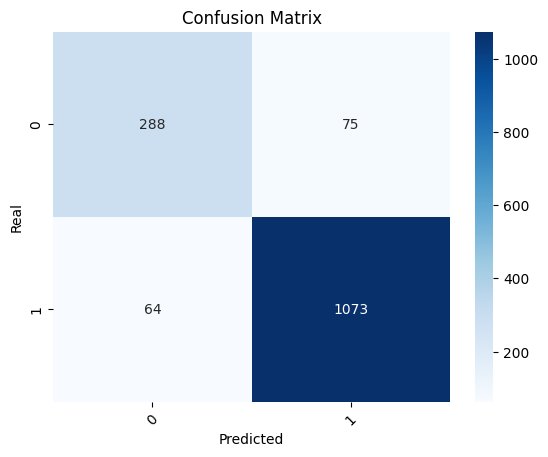

In [49]:
confusion_matrix_graph(preds_b, labels_b)

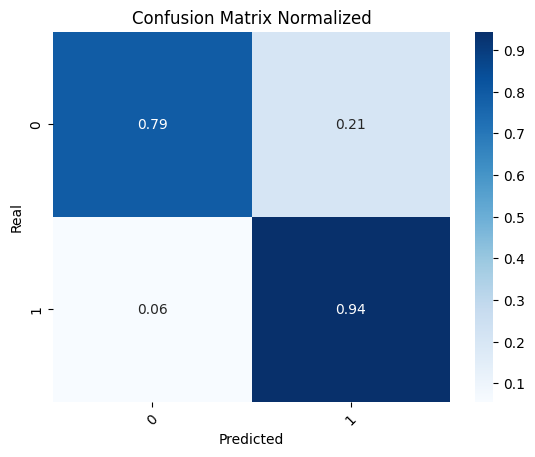

In [53]:
confusion_matrix_graph_norm(preds_b, labels_b, normalize=True)

---

### d.) Comentarios

* En cada partición de datos se toma un 30% para el conjunto de prueba, estos con el objetivo de tener las mismas propociones de datos en los datos.
* Se han calculado dos métricas pricipales para evaluar si los modelos entrenados tiene diferencias. Estas son el *accuracy* y el *f1-score*.
* El *accuracy* para los dos modelos se observa que son similares, con un valor para el primero modelo de 0.905 y para el segundo modelo de 0.907. La diferencia es pequeña considerando los resultados. De igual manera, el *f1-score* que es un métrica que de manera armónica integra el *recall* y el *precision* guarda un valor similar, para el primero modelo de 0.938 y para el segundo modelo de 0.939. Si se revisa a profundidad estas, son poco significativas las diferencias, considerando que se podrían usar los dos modelo.
* Es importante considerar un nuevo conjuntos de datos que permita evaluar si los modelos se siguen comportando de la misma manera que con un conjunto que puede guardar una similitud.
* Al observar las matrices de confusión, para el caso del primer modelo se ve que predice con un mayor porcentaje los comentarios positivos, dando un total de 95% a diferencia del segundo modelo que es de 94%.
* En el caso de los comentarios negativos, el segundo modelo lo hace mejor con un valor del 79% a diferencia del primer modelo que fue del 78%.
* Revisando las conclusiones anteriores, las diferencias son muy bajas considerando el esquema usado para el entrenamiento. Así que se puede usar cualquier modelo.
* Es importante tener en cuenta que los entrenamiento requieren de un recursos computacionales importantes en el caso de que se requiera cambiar los hiperparámetros de los modelos, es por esto que los cambias realizados son pequeños, ya que no se cuenta con los recursos necesarios.